In [343]:
import pandas as pd
import numpy as np
import folium
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Read in the Waterfall vs. Airsip CSV file
data = pd.read_csv("WaterfallvsAirsip.csv")
data

,Timestamp,Birthday (MM/DD/YYYY)\n\ni.e. 01/14/2001,Height (Answer in Inches Please)\n\ni.e. 60 inches = 5'0,Sex,Coffee or Tea?,Early Bird or Night Owl,"What is your current state of residence? Please answer in abbreviations.\n\ni.e. NJ, MD, PA, NY, CA, etc.",How long have you stayed in this state? Answer in years and can be in decimals!,Which county are you from? COUNTY not country,"What state have you lived in the longest? Write down that state(s) in abbreviation. Otherwise, write N/A","If so, how long? Write N/A if you answered ""N/A""",What do you call the action shown in the picture above?
0,11/22/2022 3:24:50,08/19/2002,61.0,Female,Tea,Night Owl,NJ,20.00,Camden,NaN,NaN,Waterfall
1,11/22/2022 3:33:28,01/10/2002,64.8,Female,Tea,Night Owl,MD,16.00,Howard,OH,4,Waterfall
2,11/22/2022 5:38:43,10/26/2002,60.0,Female,Tea,Early Bird,IN,0.17,United States,IL,19,Waterfall
3,11/22/2022 6:35:28,10/28/2000,73.0,Male,Neither,Night Owl,MD,22.00,St mary’s county,NaN,NaN,Waterfall
4,11/22/2022 7:52:55,10/23/2002,62.0,Nonbinary,Coffee,Night Owl,MD,12.50,Harford,CA,8,Waterfall
...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,12/5/1999,60.0,Female,Tea,Night Owl,NJ,2.00,NaN,WI,10,Waterfall
996,NaN,9/1/2004,63.0,Female,Tea,Night Owl,KS,5.00,NaN,CA,5,Birdie
997,NaN,7/26/1991,60.0,Female,Tea,Early Bird,WA,6.00,NaN,UT,25,Waterfall
998,NaN,9/7/1988,71.0,Male,Tea,Night Owl,TX,19.00,NaN,TX,19,Waterfall


In [344]:
# CLEANING UP THE DATA

In [345]:
# Remove the timestamp column (We will not be needing this for data analysis)
data.drop(data.columns[[0]], axis=1, inplace=True)

In [346]:
# Change column headers into more simpler terms
data.columns = ['Birthday', 'Height(in)', 'Sex', 'Coffee/Tea', 'Early Bird/Night Owl', 'Current State of Residence', 
                'Years in Current State', 'County', 'State of Longest Residence', 'Years in Longest State', 'Action']

# Change the "Birthday" column to be datetime objects
data.Birthday = pd.to_datetime(data.Birthday)
data

,Birthday,Height(in),Sex,Coffee/Tea,Early Bird/Night Owl,Current State of Residence,Years in Current State,County,State of Longest Residence,Years in Longest State,Action
0,2002-08-19,61.0,Female,Tea,Night Owl,NJ,20.00,Camden,NaN,NaN,Waterfall
1,2002-01-10,64.8,Female,Tea,Night Owl,MD,16.00,Howard,OH,4,Waterfall
2,2002-10-26,60.0,Female,Tea,Early Bird,IN,0.17,United States,IL,19,Waterfall
3,2000-10-28,73.0,Male,Neither,Night Owl,MD,22.00,St mary’s county,NaN,NaN,Waterfall
4,2002-10-23,62.0,Nonbinary,Coffee,Night Owl,MD,12.50,Harford,CA,8,Waterfall
...,...,...,...,...,...,...,...,...,...,...,...
995,1999-12-05,60.0,Female,Tea,Night Owl,NJ,2.00,NaN,WI,10,Waterfall
996,2004-09-01,63.0,Female,Tea,Night Owl,KS,5.00,NaN,CA,5,Birdie
997,1991-07-26,60.0,Female,Tea,Early Bird,WA,6.00,NaN,UT,25,Waterfall
998,1988-09-07,71.0,Male,Tea,Night Owl,TX,19.00,NaN,TX,19,Waterfall


In [347]:
# We will first replace any mispelled NaN values with real NaN values.
data = data.replace('N/a', np.nan).replace('n/a', np.nan).replace('no', np.nan).replace('No', np.nan).replace('na', np.nan).replace('Na', np.nan)

# Someone said they lived in a state for a school year. So we will approximate to 1 year.
data = data.replace('School year', 1)

# For any NaN values in the "State of Longest Residence" column we will replace it with their corresponding values in the "Current State of Residence" column.
# We will also replace NaN values in the "Years in Longest State" column with their corresponding values in the "Years in Currest State" column. 
# This is because the surveyee has not lived in another state other than their current state, which means that the current state they are living in is the state they have lived in the longest. 
data["State of Longest Residence"] = np.where(data["Years in Longest State"].isnull(), data["Current State of Residence"], data["State of Longest Residence"])
data["Years in Longest State"] = np.where(data["Years in Longest State"].isnull(), data["Years in Current State"], data["Years in Longest State"])
data

,Birthday,Height(in),Sex,Coffee/Tea,Early Bird/Night Owl,Current State of Residence,Years in Current State,County,State of Longest Residence,Years in Longest State,Action
0,2002-08-19,61.0,Female,Tea,Night Owl,NJ,20.00,Camden,NJ,20.0,Waterfall
1,2002-01-10,64.8,Female,Tea,Night Owl,MD,16.00,Howard,OH,4,Waterfall
2,2002-10-26,60.0,Female,Tea,Early Bird,IN,0.17,United States,IL,19,Waterfall
3,2000-10-28,73.0,Male,Neither,Night Owl,MD,22.00,St mary’s county,MD,22.0,Waterfall
4,2002-10-23,62.0,Nonbinary,Coffee,Night Owl,MD,12.50,Harford,CA,8,Waterfall
...,...,...,...,...,...,...,...,...,...,...,...
995,1999-12-05,60.0,Female,Tea,Night Owl,NJ,2.00,NaN,WI,10,Waterfall
996,2004-09-01,63.0,Female,Tea,Night Owl,KS,5.00,NaN,CA,5,Birdie
997,1991-07-26,60.0,Female,Tea,Early Bird,WA,6.00,NaN,UT,25,Waterfall
998,1988-09-07,71.0,Male,Tea,Night Owl,TX,19.00,NaN,TX,19,Waterfall


In [348]:
# Below, we have the same person who submitted twice. They realized they made a mistake a requested to delete their previous response.
print(data.iloc[85])
print()
print(data.iloc[86])

Birthday                      2003-08-20 00:00:00
Height(in)                                   60.0
Sex                                        Female
Coffee/Tea                                    Tea
Early Bird/Night Owl                   Early Bird
Current State of Residence                     CA
Years in Current State                       19.0
County                                        USA
State of Longest Residence                     CA
Years in Longest State                       19.0
Action                                  Waterfall
Name: 85, dtype: object

Birthday                                            2003-08-20 00:00:00
Height(in)                                                         60.0
Sex                                                              Female
Coffee/Tea                                                          Tea
Early Bird/Night Owl                                         Early Bird
Current State of Residence                                       

In [349]:
# Let's modify her first response (row 85) and delete her second response
data.iat[85,7] = 'Alameda'
data.iat[85,8] = 'CA'
data.iat[85,9] = 19.0

# Lets check our work
print(data.iloc[85])

# Drop the extra row
data.drop(86,axis=0,inplace=True)

# We can see that row 86 has been dropped and 85 has been modified correctly
data[83:87]

Birthday                      2003-08-20 00:00:00
Height(in)                                   60.0
Sex                                        Female
Coffee/Tea                                    Tea
Early Bird/Night Owl                   Early Bird
Current State of Residence                     CA
Years in Current State                       19.0
County                                    Alameda
State of Longest Residence                     CA
Years in Longest State                       19.0
Action                                  Waterfall
Name: 85, dtype: object


,Birthday,Height(in),Sex,Coffee/Tea,Early Bird/Night Owl,Current State of Residence,Years in Current State,County,State of Longest Residence,Years in Longest State,Action
83,2001-10-01,69.0,Male,Tea,Early Bird,IL,1.5,Taiwan 🇹🇼,IL,1.5,No term for this
84,2000-02-05,59.0,Female,Neither,Early Bird,MD,22.0,Montgomery,MD,22.0,Airsip
85,2003-08-20,60.0,Female,Tea,Early Bird,CA,19.0,Alameda,CA,19.0,Waterfall
87,2003-04-06,60.0,Female,Tea,Night Owl,CA,19.0,Alameda County,CA,19.0,Waterfall


In [350]:
# Some other rows we can drop are responses from surveyees who do not answer the questions appropriately
# We will remove these three since they do not give much relevant information. (No states were mentioned, height of the person is impossible, etc.)

print(data.loc[19])
print()
print(data.loc[33])
print()
print(data.loc[183])

Birthday                      1999-11-11 00:00:00
Height(in)                                    1.0
Sex                                        Female
Coffee/Tea                                    Tea
Early Bird/Night Owl                   Early Bird
Current State of Residence                     RM
Years in Current State                        7.0
County                                        BTS
State of Longest Residence          Seokjin oppar
Years in Longest State                          7
Action                          Holy juice drip 🤤
Name: 19, dtype: object

Birthday                      2001-01-07 00:00:00
Height(in)                                   70.0
Sex                                          Male
Coffee/Tea                                    Tea
Early Bird/Night Owl                    Night Owl
Current State of Residence                     MD
Years in Current State                       17.5
County                                       Here
State of Longest Residenc

In [351]:
# Drop the first one
data.drop(19,axis=0,inplace=True)
data[17:22]

,Birthday,Height(in),Sex,Coffee/Tea,Early Bird/Night Owl,Current State of Residence,Years in Current State,County,State of Longest Residence,Years in Longest State,Action
17,2002-11-08,69.0,Female,Tea,Night Owl,MD,19.0,Montgomery,TX,1,Airsip
18,2002-01-15,71.0,Male,Coffee,Night Owl,MD,20.9,United States,MD,20.9,Airsip
20,2002-02-13,67.0,Female,Tea,Night Owl,MD,19.2,USA,MD,19.2,Airsip
21,2002-04-01,66.0,Female,Coffee,Night Owl,MD,20.0,United States of America,MD,20.0,Airsip
22,2002-08-21,67.0,Female,Tea,Night Owl,MD,18.0,Montgomery County,VA,2 years,Airsip


In [352]:
# Drop the second one
data.drop(33,axis=0,inplace=True)
data[30:36]

,Birthday,Height(in),Sex,Coffee/Tea,Early Bird/Night Owl,Current State of Residence,Years in Current State,County,State of Longest Residence,Years in Longest State,Action
31,2002-08-02,70.0,Male,Coffee,Night Owl,NJ,4.0,Middlesex,"New York, Massachussets, California","3, 7, 3, 4",Waterfall
32,2001-03-12,64.0,Female,Neither,Early Bird,MD,20.0,Wicomico,MD,20.0,Waterfall
34,2001-04-02,61.0,Female,Tea,Night Owl,MD,21.0,Prince George's County,MD,21.0,Waterfall
35,1985-01-15,69.0,Male,Coffee,Night Owl,NJ,29.0,Morris,"MD,PA,NY,VT","8,2.5,4,1",Waterfall
36,2003-12-29,68.0,Male,Neither,Night Owl,MD,18.8,US,MD,18.8,Airsip
37,2001-04-27,62.0,Female,Coffee,Night Owl,MD,18.0,Wicomico,MD,18.0,Waterfall


In [353]:
# Drop the third one
data.drop(183,axis=0,inplace=True)
data[176:183]

,Birthday,Height(in),Sex,Coffee/Tea,Early Bird/Night Owl,Current State of Residence,Years in Current State,County,State of Longest Residence,Years in Longest State,Action
179,2002-05-06,62.00,Female,Tea,Night Owl,MD,1.5,India,PA,16,Waterfall
180,2004-10-01,62.00,Female,Coffee,Night Owl,NJ,14.0,USA,"KY, NC","2,2",Waterfall
181,2006-04-05,69.00,Female,Coffee,Night Owl,NJ,11.0,"Wake county, NC","NC, Perth (australia)","NC (1), Perth (4)",Waterfall
182,2000-12-26,68.75,Female,Tea,Night Owl,MD,22.0,Baltimore County,MD,22.0,Waterfall
184,1969-06-05,71.50,Male,Coffee,Early Bird,ID,20.5,Ada,"TX, CA, WI, MS, AZ","3, 25.5, 2, .75, 1",No term for this
185,1974-10-29,65.00,Male,Coffee,Early Bird,IA,40.0,USA,IA,40.0,Pourgnorgin
186,1996-08-21,72.00,Male,Coffee,Night Owl,MT,7.2,Missoula,NJ,18,Waterfall


In [354]:
# We had originally asked the surveyees to provide all of the other states they have lived in, and how many years they lived in each state.
# This is why at first, the some of the states and years in "State of Longest Residence" (Column 9) and "Years in Longest State" (Column 10) are separated by commas, where each year corresponds to a state.
# For example, Column 9: MD, UT, AR | Column 10: 3, 1, 2 --> this means that they lived in MD for 3 years, UT for 1 year and AR for 2 years.
# Lets narrow these values down to just the state they lived in the longest and its corresponding year.

In [355]:
# We will first clean up the states in the "State of Longest Residence" and "Years in Longest State" column
# We want all states to be abbreviated and uppercase (i.e. MD)

# First, make a list of all states abbreviated in uppercase
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

# Next, make a list of the full names of all states in uppercase in the same order as the abbreviations in the 'states' list above.
states_full = [ 'ALASKA', 'ALABAMA', 'ARKANSAS', 'ARIZONA', 'CALIFORNIA', 'COLORADO', 'CONNECTICUT', 'DISTRICT OF COLUMBIA', 
               'DELAWARE', 'FLORIDA', 'GEORGIA', 'HAWAII', 'IOWA', 'IDAHO', 'ILLINOIS', 'INDIANA', 'KANSAS', 'KENTUCKY', 
               'LOUISIANA', 'MASSACHUSSETS', 'MARYLAND', 'MAINE', 'MICHIGAN', 'MINNESOTA', 'MISSOURI', 'MISSISSIPPI', 
               'MONTANA', 'NORTH CAROLINA', 'NORTH DAKOTA', 'NEBRASKA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO', 'NEVADA', 
               'NEW YORK', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA', 'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA', 
               'TENNESSEE', 'TEXAS', 'UTAH', 'VIRGINIA', 'VERMONT', 'WASHINGTON', 'WISCONSIN', 'WEST VIRGINIA', 'WYOMING']
# Note: MASSACHUSETTS is intentionally misspelled as MASSACHUSSETS because one surveyee mispelled it. 
# In order to identify it in our loop we intentionally misspell it.

# Now we will begin with the cleaning process by iterating through all rows in the dataset
for idx, row in data.iterrows():
    
    # Here we get rid of the commas separating the state and year values in the current row
    txt = str(row["State of Longest Residence"]).split(',')
    years = str(row["Years in Longest State"]).split(',')
    
    # We will add cleaned states and years in the lists below:
    # List of state abbreviations for every response in "State of Longest Residence" in the current row
    sts = []
    # List of years for every response in "Years in Longest State" in the current row
    yrs = []
    
    # Iterating through each value(state/location) in txt
    for x in txt:
        
        # The index of x in txt will be used to locate its corresponding value in the list of years
        i = txt.index(x)
        
        # Here we account for any responses with the full state name instead of the abbreviation
        # We also get rid of any leading and trailing whitespace using strip()
        if x.strip().upper() in states_full:
            
            # We look at where x is in the states_full list and use that index to append its corresponding state in abbreviations to the 'sts' list
            sts.append(states[states_full.index(x.strip().upper())])
            
            # With this regex, we only extract the numbers from the provided years. 
            # This is because some responses included the word "year" or "month" instead of just a number
            yr = re.findall("(?:\d+(?:\.\d*)?|\.\d+)", years[i].strip())[0]
            
            # Some responses include the number of months, so we convert those into years
            if "month" in years[i]:
                yr = float(yr)/12.0
            
            
            yrs.append(yr)
            
        # Here we check if it is a state abbreviation
        elif x.strip().upper() in states:
            sts.append(x.strip().upper())
            
            yr = re.findall("(?:\d+(?:\.\d*)?|\.\d+)", years[i].strip())[0]
            
            if "month" in years[i]:
                yr = float(yr)/12.0
                
            yrs.append(yr)
        # If it is not a state at all then do nothing 
        # This ensures that anything that is not a state does not get added to a list
        else:
            continue
    
    # Modify each cell into the cleaner lists of states and years
    data.at[idx, "State of Longest Residence"] = sts
    data.at[idx, "Years in Longest State"] = yrs
    
data.head(38)

,Birthday,Height(in),Sex,Coffee/Tea,Early Bird/Night Owl,Current State of Residence,Years in Current State,County,State of Longest Residence,Years in Longest State,Action
0,2002-08-19,61.0,Female,Tea,Night Owl,NJ,20.00,Camden,[NJ],[20.0],Waterfall
1,2002-01-10,64.8,Female,Tea,Night Owl,MD,16.00,Howard,[OH],[4],Waterfall
2,2002-10-26,60.0,Female,Tea,Early Bird,IN,0.17,United States,[IL],[19],Waterfall
3,2000-10-28,73.0,Male,Neither,Night Owl,MD,22.00,St mary’s county,[MD],[22.0],Waterfall
4,2002-10-23,62.0,Nonbinary,Coffee,Night Owl,MD,12.50,Harford,[CA],[8],Waterfall
5,2002-05-20,60.0,Female,Tea,Early Bird,MD,20.50,St. Mary’s County,[MD],[20.5],Waterfall
6,2002-05-03,66.0,Female,Tea,Night Owl,MD,20.50,United States,[MD],[20.5],Waterfall
7,2001-09-04,76.0,Male,Tea,Night Owl,MD,21.00,USA,[MD],[21.0],Waterfall
8,2004-08-03,65.0,Female,Neither,Night Owl,MD,5.00,Howard,[TX],[5],Waterfall
9,2002-04-18,62.0,Female,Tea,Night Owl,MD,7.40,United States,"[KY, IA]","[6, 5]",Waterfall


In [356]:
# Now that we have cleaned up those two columns, we can go through each row to see which state was lived in the longest for each response
for idx, row in data.iterrows():
    # Convert each list of years to floats so we can compare
    lst = [float(x) for x in row["Years in Longest State"]]
    
    # If the list of years is empty, set both the year and state values to NaN
    if len(lst)==0:
        data.at[idx, "Years in Longest State"] = np.nan
        data.at[idx, "State of Longest Residence"] = np.nan
    
    # If there is only one year in the list then the corresponding state is automatically the state most lived in
    elif len(lst)==1:
        data.at[idx, "Years in Longest State"] = lst[0]
        data.at[idx, "State of Longest Residence"] = row["State of Longest Residence"][0]
        
    # If there is more than one year in the list then we compare them and choose the max year
    # This max year will replace the current list in "Years in Longest State" and its corresponding state will replace the current list in "State of Longest Residence"
    else:
        max_yr = max(lst)
        data.at[idx, "Years in Longest State"] = max_yr
        i = lst.index(max_yr)
        data.at[idx, "State of Longest Residence"] = row["State of Longest Residence"][i]

In [357]:
# We update any NaN values as we did previously. Where the current state and year replace the longest state and year that are NaN.
data["State of Longest Residence"] = np.where(data["Years in Longest State"].isnull(), data["Current State of Residence"], data["State of Longest Residence"])
data["Years in Longest State"] = np.where(data["Years in Longest State"].isnull(), data["Years in Current State"], data["Years in Longest State"])
data.head(38)

,Birthday,Height(in),Sex,Coffee/Tea,Early Bird/Night Owl,Current State of Residence,Years in Current State,County,State of Longest Residence,Years in Longest State,Action
0,2002-08-19,61.0,Female,Tea,Night Owl,NJ,20.00,Camden,NJ,20.0,Waterfall
1,2002-01-10,64.8,Female,Tea,Night Owl,MD,16.00,Howard,OH,4.0,Waterfall
2,2002-10-26,60.0,Female,Tea,Early Bird,IN,0.17,United States,IL,19.0,Waterfall
3,2000-10-28,73.0,Male,Neither,Night Owl,MD,22.00,St mary’s county,MD,22.0,Waterfall
4,2002-10-23,62.0,Nonbinary,Coffee,Night Owl,MD,12.50,Harford,CA,8.0,Waterfall
5,2002-05-20,60.0,Female,Tea,Early Bird,MD,20.50,St. Mary’s County,MD,20.5,Waterfall
6,2002-05-03,66.0,Female,Tea,Night Owl,MD,20.50,United States,MD,20.5,Waterfall
7,2001-09-04,76.0,Male,Tea,Night Owl,MD,21.00,USA,MD,21.0,Waterfall
8,2004-08-03,65.0,Female,Neither,Night Owl,MD,5.00,Howard,TX,5.0,Waterfall
9,2002-04-18,62.0,Female,Tea,Night Owl,MD,7.40,United States,KY,6.0,Waterfall


In [358]:
# Lets take a look at the unique values in the "Current State of Residence" column.
print(pd.unique(data["Current State of Residence"]))

['NJ' 'MD' 'IN' 'PA' 'TX' 'VA' 'IL' 'Tx' 'WA' 'KS' 'CA' 'NV' 'ca' 'NE'
 'Nv' 'NH' 'NC' 'MA' 'Md' 'ID' 'IA' 'MT' 'Id' 'OK' 'Ak' 'UT' 'AK' 'WY'
 'AZ' 'ME' 'DC' 'WI' 'OH' 'WV' 'MI' 'TN' 'FL' 'AL' 'NM' 'GA' 'DE' 'NY'
 'MO' 'VT' 'MS' 'SC' 'HI' 'ND' 'OR' 'KY' 'RI' 'SD' 'CT' 'AR' 'CO' 'LA'
 'MN']


In [359]:
# Since the state abbreviations are not all capitalized, we will capitalize them.
data["Current State of Residence"] = data["Current State of Residence"].apply(lambda x: x.upper())
# Now they are all upper case.
print(pd.unique(data["Current State of Residence"]))

['NJ' 'MD' 'IN' 'PA' 'TX' 'VA' 'IL' 'WA' 'KS' 'CA' 'NV' 'NE' 'NH' 'NC'
 'MA' 'ID' 'IA' 'MT' 'OK' 'AK' 'UT' 'WY' 'AZ' 'ME' 'DC' 'WI' 'OH' 'WV'
 'MI' 'TN' 'FL' 'AL' 'NM' 'GA' 'DE' 'NY' 'MO' 'VT' 'MS' 'SC' 'HI' 'ND'
 'OR' 'KY' 'RI' 'SD' 'CT' 'AR' 'CO' 'LA' 'MN']


In [360]:
# Lets look at the unique values in the "Actions" column
print(pd.unique(data["Action"]))

['Waterfall' 'Airsip' 'gluck gluck 3000' 'No term for this' 'Birdie'
 'Birdie Sip' 'Sky "Let me sky that"' 'Fountain' 'Airdrink 🙃'
 'I use waterfall and airship interchangeably' 'Pourgnorgin' 'Chug' 'Sky'
 'Pop' 'Airdrink']


In [361]:
# It seems that we can simplify some of these. We make it so that:
# "Birdie Sip" = "Birdie"
# "Sky "Let me sky that"" = "Sky"
# "Airdrink 🙃" = "Airdrink"
# "I use waterfall and airship interchangeably" = "Airsip"

print(data.at[115,"Action"])
data.at[115,"Action"] = 'Birdie'

print(data.at[127,"Action"])
data.at[127,"Action"] = 'Sky'

print(data.at[152,"Action"])
data.at[152,"Action"] = 'Airdrink'

print(data.at[178,"Action"])
data.at[178,"Action"] = 'Airsip'

Birdie Sip
Sky "Let me sky that"
Airdrink 🙃
I use waterfall and airship interchangeably


## Data Analysis

Let's do some data analysis now! We want to see which of the attributes has the strongest correlation to the Action Terms. We will show how the Action Terms vary for each of the attributes such as Sex, Age, Drink of Preference, and Early Bird/Night Owl.

#### Action vs. Sex

We want to compare the Action Term and Sex now. With this new dataframe below, we can see the counts of how many people in each sex define the action. There were two rows with the Sex "Nonbinary" but they were formatted differently, so we combined them and dropped that second instance. We also ended up dropping the row with the Sex as "yes please" because that is not a valid option that we are considering for this project.

In [362]:
# Making the new df
gen_act = data.groupby(['Sex', 'Action']).size().reset_index(name='Counts')
gen_act.at[19,'Counts']= 2
gen_act = gen_act.drop([20,21])
gen_act

,Sex,Action,Counts
0,Female,Airdrink,9
1,Female,Airsip,60
2,Female,Birdie,12
3,Female,Fountain,7
4,Female,No term for this,18
5,Female,Pop,3
6,Female,Sky,9
7,Female,Waterfall,407
8,Male,Airdrink,9
9,Male,Airsip,39


Now, let's plot the data into a Bar Plot.

Text(0, 0.5, 'Number of People')

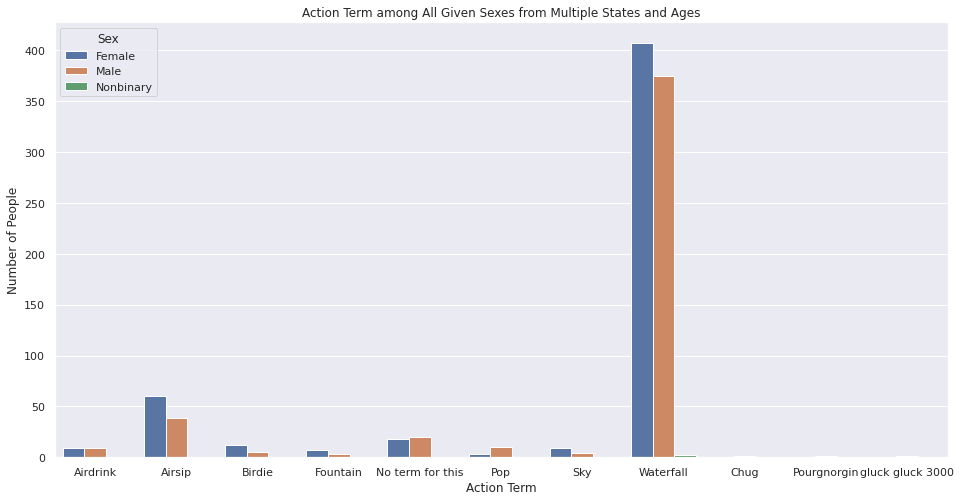

In [363]:
# Making the barplot and formating the graph so it is readable
plt.figure(figsize=(16,8))
sns.barplot(data=gen_act, x="Action", y="Counts", hue="Sex")
plt.title("Action Term among All Given Sexes from Multiple States and Ages", fontsize = 12)
plt.xlabel("Action Term", fontsize = 12)
plt.ylabel("Number of People", fontsize = 12)

For this attribute (Sex), we decided to use a Bar Plot instead of a Violin plot for a couple reasons. First, we have 3 different Sexes given to us, Female, Male, and Nonbinary. Due to this, the representation of data that would best fit would be a Bar Plot. We can see that the term "Waterfall" is the most popular among Males and Females. From this plot, we can see that for "Airsip", "Waterfall", "Birdie", "Fountain", and "Sky", Females had the highest count. We can also see that for "No term for this", "Pop", "Chug", "Pourgnorgin", and "gluck gluck 3000", Males had the highest count. For "Airdrink", there is a tie for Males and Females. The Nonbinary sex had two entries, both under "Waterfall". 

#### Action vs. Age

Now, let's compare the Action Term against Age. The first thing we need to do is calculate the ages of the respondants because we do not have a column for that yet. We can make this by using their Birthdays which we required them to input. We wanted to create a new dataframe to look at the age distribution before comparing it against the Action Term. Below, we made this dataframe and transposed it to have the ages as the columns.

In [364]:
## Calculating the Age from Birthdays and adding it to a new column in df
today = datetime.today()
data['Age'] = data['Birthday'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))


ages = data.groupby(['Age']).size().reset_index(name='Count')
# ^ This will get the number of times each Age occurs in our data
ages = ages.transpose() 
pd.set_option('display.max_columns', None)
ages.columns = ages.iloc[0]
ages = ages[1:]
ages

Age,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,51,53,63,67
Count,1,2,15,16,72,91,119,121,78,81,75,54,12,12,12,11,20,18,11,10,13,13,9,7,16,15,7,13,6,10,5,17,14,15,1,1,1,1,1


<Figure size 1152x576 with 0 Axes>

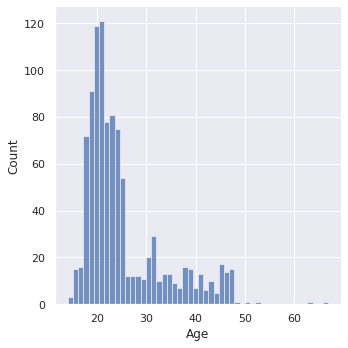

In [365]:
plt.figure(figsize=(16,8))
sns.displot(data, x="Age", bins = 50)

Just taking a look at our data, we see that most of the respondants are in aged 18-25 years old. We should keep this in mind when we are looking at the violin plots for each term. We are expecting to see unimodal or bimodal violins with the highest expectancies for each term around the ages of 18-25. 

Text(0, 0.5, 'Age (in Years)')

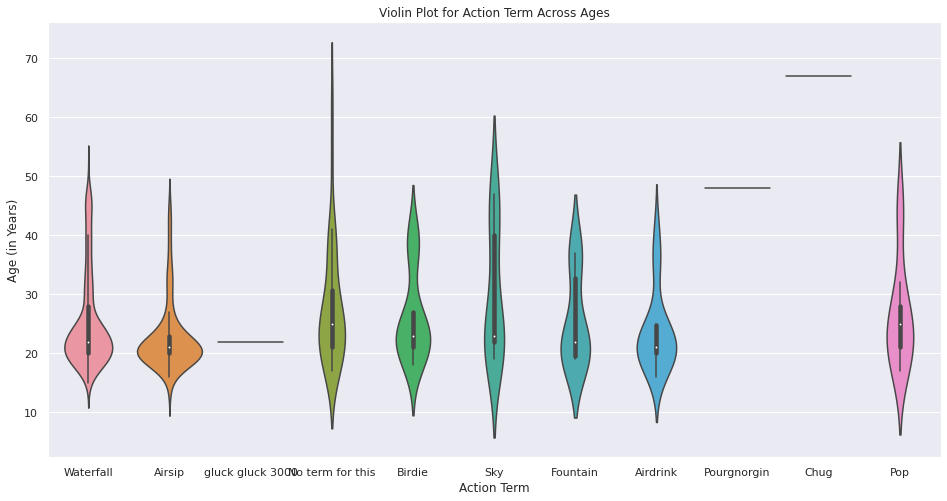

In [366]:
# Plotting to compare terms and highest expectacny for ages
plt.figure(figsize=(16,8))
sns.violinplot(data=data, x="Action", y="Age")
plt.title("Violin Plot for Action Term Across Ages", fontsize = 12)
plt.xlabel("Action Term", fontsize = 12)
plt.ylabel("Age (in Years)", fontsize = 12)

From this violin plot, we can see that the term "Waterfall" is unimodal, used mostly among people around the age of 20, which is where the media lies. "Waterfall" is also somewhat used evenly across ages 30-48 years old. The term "Airsip" is also unimodal, used very heavily for people around the age of 20. The "Airsip" distribution across ages is not a lot. We see that the term "gluck gluck 3000" is on the x-axis but there is no violin plot for it. This is because only one person responded with that. For the response "No term for this," we can see that the ages range all the way up to 70 years-old. It looks unimodal, between 20-30 years-old, but it is not as prominent as "Waterfall" or "Airsip". The median for this term lies around 25 years-old. The term "Birdie" is bimodal, but the higher probability is around the ages 20-30 years-old. The second highest is around 40 years-old. The term "Sky" is also biomodal. 

#### Correlation Matrix

In [368]:
# We need a new dataframe for the matrix
df = data
# Turning the types into numerical values so the .corr() function can do the calculations
df['Current State'] = data['Current State of Residence'].astype('category').cat.codes
df['Gender'] = data['Sex'].astype('category').cat.codes
df['Drink'] = data['Coffee/Tea'].astype('category').cat.codes
df['Early/Night'] = data['Early Bird/Night Owl'].astype('category').cat.codes
df['Longest State'] = data['State of Longest Residence'].astype('category').cat.codes
df['Years in Longest State'] = df['Years in Longest State'].astype(int)
df['Term'] = data['Action'].astype('category').cat.codes
df = df.drop(columns = ['Current State of Residence', 'Action', 'Sex', 'Coffee/Tea', 'Early Bird/Night Owl', 'State of Longest Residence'])
# Making the correlation matrix here
correlation_matrix = df.corr()
correlation_matrix

,Height(in),Years in Current State,Years in Longest State,Age,Current State,Gender,Drink,Early/Night,Longest State,Term
Height(in),1.000000,0.031351,0.025715,0.006320,0.047571,0.268460,-0.039771,0.024336,0.053489,0.031867
Years in Current State,0.031351,1.000000,0.679708,0.290059,-0.017315,0.012880,-0.017395,0.024233,0.007441,-0.053148
Years in Longest State,0.025715,0.679708,1.000000,0.501793,0.018223,0.007497,-0.036944,-0.056191,-0.017370,0.005489
Age,0.006320,0.290059,0.501793,1.000000,0.021232,0.081062,-0.055607,-0.076273,0.004848,0.063689
Current State,0.047571,-0.017315,0.018223,0.021232,1.000000,0.067509,0.007301,-0.054083,0.494520,0.059341
Gender,0.268460,0.012880,0.007497,0.081062,0.067509,1.000000,-0.012358,0.034360,0.053996,0.032041
Drink,-0.039771,-0.017395,-0.036944,-0.055607,0.007301,-0.012358,1.000000,0.018147,0.038709,0.006894
Early/Night,0.024336,0.024233,-0.056191,-0.076273,-0.054083,0.034360,0.018147,1.000000,0.017961,-0.014797
Longest State,0.053489,0.007441,-0.017370,0.004848,0.494520,0.053996,0.038709,0.017961,1.000000,0.061732
Term,0.031867,-0.053148,0.005489,0.063689,0.059341,0.032041,0.006894,-0.014797,0.061732,1.000000


Now, let's turn this into a heatmap using the Seaborn Heatmap function. 

<AxesSubplot:>

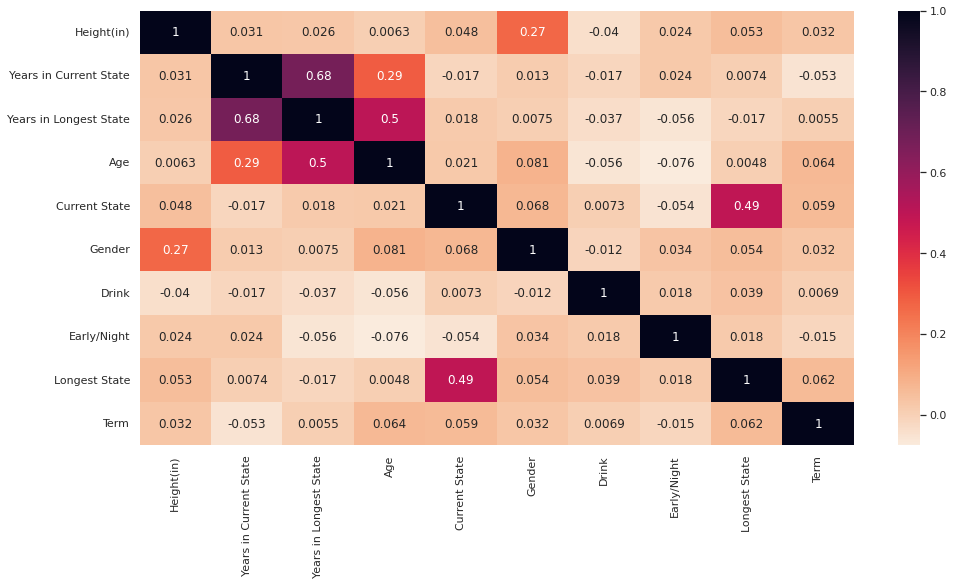

In [376]:
cmap = sns.cm.rocket_r
plt.figure(figsize=(16,8))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap)

In creating this heatmap, it originally displayed it with the weakest correlation as the darkest colors and the strongest with the lightest colors. This is not how we wanted to display our heatmap. We want to display the strongest correlation as the darkest color because we want to emphasize these cells the most. So to fix this issue, we flipped the color scale. 

Now, looking at this correlation heatmap, we want to look at the far right column or the last row. This is because we want to see how each of the attributes correlates to the Action Term. The Term and Term cell should be the darkest cell because it has the strongest possible correlation with each other. We can see that this is a pattern down the diagonal of the matrix, the attributes have the strongest correlations with themselves. Now, in the Term column, we want the darkest cells aside from the Term attribute. 

At first glance, not looking at the values, the next darkest cells are for Longest State, Age, and Current State. As a group, we were expecting the strongest correlation to be with either Current State or Longest State. But from this heatmap, we can see that the strongest attribute is Age at 0.64, greater than Longest State by 0.002.